In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Video classification

Video classification is the task of assigning a label or class to an entire video. Videos are expected to have only one class for each video. Video classification models take a video as input and return a prediction about which class the video belongs to. These models can be used to categorize what a video is all about. A real-world application of video classification is action / activity recognition, which is useful for fitness applications. It is also helpful for vision-impaired individuals, especially when they are commuting.

This guide will show you how to:

1. Fine-tune [VideoMAE](https://huggingface.co/docs/transformers/main/en/model_doc/videomae) on a subset of the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) dataset.
2. Use your fine-tuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[TimeSformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/timesformer), [VideoMAE](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/videomae)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q pytorchvideo transformers evaluate
```

You will use [PyTorchVideo](https://pytorchvideo.org/) (dubbed `pytorchvideo`) to process and prepare the videos.

We encourage you to log in to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to log in:

In [2]:
import os
from huggingface_hub import HfFolder

# Read token from environment variable (more secure)
# You can set this environment variable before running the notebook
# export HUGGINGFACE_TOKEN=your_token_here (Linux/Mac)
# set HUGGINGFACE_TOKEN=your_token_here (Windows)
token = os.getenv("HUGGINGFACE_TOKEN")

if token:
    HfFolder.save_token(token)
    print("Hugging Face token successfully loaded from HUGGINGFACE_TOKEN environment variable.")
else:
    print("HUGGINGFACE_TOKEN environment variable not set. If you want to push models to the Hub, please set this variable before starting Jupyter Lab.")

# Commenting out other options to keep the cell clean
# Option 1: Set token directly in code (not recommended for shared notebooks)
# HfFolder.save_token("your_token_here")

# Option 3: Load token from a file (more secure)
# token_path = "path/to/token.txt"
# if os.path.exists(token_path):
#     with open(token_path, "r") as f:
#         token = f.read().strip()
#     HfFolder.save_token(token)
#     print("Hugging Face token successfully loaded from file.")
# else:
#     print(f"Token file not found at {token_path}")

Hugging Face token successfully loaded from HUGGINGFACE_TOKEN environment variable.


In [3]:
# Use Kinetics-finetuned base as the starting point (better transfer for sports actions)
model_ckpt = "MCG-NJU/videomae-small-finetuned-ssv2"

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-sports-videos-in-the-wild"

## Load Sports in the Wild dataset

Start by loading a subset of the [SVW dataset](https://cvlab.cse.msu.edu/project-svw.html). This will give you a chance to experiment and make sure everything works before spending more time training on the full dataset.

In [4]:
import os

# Set the path to the local processed dataset folder
dataset_root_path = "processed_dataset"
all_video_file_paths = []

# Read train, validation and test file paths from CSV files
with open(os.path.join(dataset_root_path, "train.csv"), "r") as f:
    train_paths = [line.strip().split()[0] for line in f.readlines()]
    all_video_file_paths.extend([os.path.join(dataset_root_path, path) for path in train_paths])
    
with open(os.path.join(dataset_root_path, "val.csv"), "r") as f:
    val_paths = [line.strip().split()[0] for line in f.readlines()]
    all_video_file_paths.extend([os.path.join(dataset_root_path, path) for path in val_paths])
    
with open(os.path.join(dataset_root_path, "test.csv"), "r") as f:
    test_paths = [line.strip().split()[0] for line in f.readlines()]
    all_video_file_paths.extend([os.path.join(dataset_root_path, path) for path in test_paths])

print(f"Total video files: {len(all_video_file_paths)}")

Total video files: 4206


After the subset has been downloaded, you need to extract the compressed archive:

In [5]:
import os

# Just verify that the videos directory exists
videos_dir = os.path.join(dataset_root_path, "videos")
if os.path.exists(videos_dir):
    print(f"Videos directory exists at {videos_dir}")
    print(f"Number of video files: {len(os.listdir(videos_dir))}")
else:
    print(f"Warning: Videos directory not found at {videos_dir}")

Videos directory exists at processed_dataset\videos
Number of video files: 4206


In [6]:
import os

# Assuming dataset_root_path is defined
# dataset_root_path = "path_to_your_dataset"

# Get labels from CSV files
labels = []

with open(os.path.join(dataset_root_path, "train.csv"), "r") as f:
    for line in f.readlines():
        parts = line.strip().split()
        if len(parts) > 1:
            labels.append(parts[1])

with open(os.path.join(dataset_root_path, "val.csv"), "r") as f:
    for line in f.readlines():
        parts = line.strip().split()
        if len(parts) > 1:
            labels.append(parts[1])
            
with open(os.path.join(dataset_root_path, "test.csv"), "r") as f:
    for line in f.readlines():
        parts = line.strip().split()
        if len(parts) > 1:
            labels.append(parts[1])

# Get unique labels and create mappings
class_labels = sorted(set(labels))
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {len(label2id)}.")
print(f"Class labels: {class_labels}")

Unique classes: 30.
Class labels: ['archery', 'baseball', 'basketball', 'bmx', 'bowling', 'boxing', 'cheerleading', 'discusthrow', 'diving', 'football', 'golf', 'gymnastics', 'hammerthrow', 'highjump', 'hockey', 'hurdling', 'javelin', 'longjump', 'polevault', 'rowing', 'running', 'shotput', 'skating', 'skiing', 'soccer', 'swimming', 'tennis', 'volleyball', 'weight', 'wrestling']


There are 30 unique classes.

## Load a model to fine-tune

Instantiate a video classification model from a pretrained checkpoint and its associated image processor. The model's encoder comes with pre-trained parameters, and the classification head is randomly initialized. The image processor will come in handy when writing the preprocessing pipeline for our dataset.

In [5]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

C:\Users\order\.conda\envs\videomae\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\order\.cache\huggingface\hub\models--MCG-NJU--videomae-small-finetuned-ssv2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/87.8M [00:00<?, ?B/s]

C:\Users\order\.conda\envs\videomae\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-small-finetuned-ssv2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([174, 384]) in the checkpoint and torch.Size([30, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([174]) in the checkpoint and torch.Size([30]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'h

While the model is loading, you might notice the following warning:

```bash
Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: [..., 'decoder.decoder_layers.1.attention.output.dense.bias', 'decoder.decoder_layers.2.attention.attention.key.weight']
- This IS expected if you are initializing VideoMAEForVideoClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VideoMAEForVideoClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some others (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics`.

## Prepare the datasets for training

For preprocessing the videos, you will leverage the [PyTorchVideo library](https://pytorchvideo.org/). Start by importing the dependencies we need.

In [6]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

C:\Users\order\.conda\envs\videomae\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


For the training dataset transformations, use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, keep the same transformation chain except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorchVideo](https://pytorchvideo.org).  

Use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

Start by defining some constants.

In [7]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

Now, define the dataset-specific transformations and the datasets respectively. Starting with the training set:

In [8]:
# Define batch size
batch_size = 8

# Define the transforms for training data
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Helper function to load labeled video paths from a CSV
# This function assumes 'os' module is imported, and 
# 'dataset_root_path' and 'label2id' are defined in the global scope of the notebook.
def load_labeled_video_paths(csv_filename, root_dir_for_csv_paths, label_to_id_map):
    labeled_paths = []
    # Construct the full path to the CSV file
    csv_path = os.path.join(root_dir_for_csv_paths, csv_filename)
    with open(csv_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 2:
                video_path_in_csv = parts[0]  # e.g., "videos/video_000000.mp4"
                label_str = parts[1]
                
                # Construct the full path to the video file
                # root_dir_for_csv_paths is dataset_root_path (e.g., "processed_dataset")
                full_video_path = os.path.join(root_dir_for_csv_paths, video_path_in_csv)
                
                if label_str in label_to_id_map:
                    label_id = label_to_id_map[label_str]
                    labeled_paths.append((full_video_path, {"label": label_id}))
                else:
                    print(f"Warning: Label '{label_str}' not in label2id map for video {full_video_path}. Skipping.")
            elif line.strip(): # Avoid warning for empty lines if any
                print(f"Warning: Malformed line in {csv_path}: '{line.strip()}'")
    return labeled_paths

# Load labeled video paths for training
# dataset_root_path, label2id, clip_duration, and train_transform are assumed to be defined in previous cells.
labeled_video_paths_train = load_labeled_video_paths("train.csv", dataset_root_path, label2id)

# Create LabeledVideoDataset for training
train_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths=labeled_video_paths_train,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

The same sequence of workflow can be applied to the validation and evaluation sets:

In [9]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Load labeled video paths for validation
# dataset_root_path, label2id, clip_duration, and val_transform are assumed to be defined in previous cells.
# The load_labeled_video_paths function is defined in the previous cell.
labeled_video_paths_val = load_labeled_video_paths("val.csv", dataset_root_path, label2id)

val_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths=labeled_video_paths_val,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

# Load labeled video paths for test
labeled_video_paths_test = load_labeled_video_paths("test.csv", dataset_root_path, label2id)

test_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths=labeled_video_paths_test,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform, # Using val_transform for test set as well
)

**Note**: The above dataset pipelines are taken from the [official PyTorchVideo example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorchVideo dataset. So, if you want to use a custom dataset not supported off-the-shelf by PyTorchVideo, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

You can access the `num_videos` argument to know the number of videos in the dataset.

In [10]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

3364 420 422


model.safetensors:   0%|          | 0.00/87.8M [00:00<?, ?B/s]

## Visualize the preprocessed video for better debugging

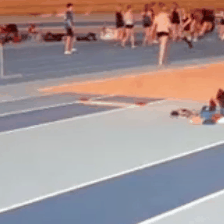

In [12]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/sample_gif.gif" alt="Person playing basketball"/>
</div>

## Train the model

Leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, you need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in this case, you need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [13]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-sports-videos-in-the-wild"
num_epochs = 20

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

The dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__` method. As such, we must define `max_steps` when instantiating `TrainingArguments`.

Next, you need to define a function to compute the metrics from the predictions, which will use the `metric` you'll load now. The only preprocessing you have to do is to take the argmax of our predicted logits:

In [14]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Multiclass metrics: macro/weighted

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    acc = accuracy_score(labels, preds)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)

    # Return only scalars to avoid logging/serialization errors
    return {
        'accuracy': acc,
        'macro_precision': precision_macro,
        'macro_recall': recall_macro,
        'macro_f1': f1_macro,
        'weighted_precision': precision_weighted,
        'weighted_recall': recall_weighted,
        'weighted_f1': f1_weighted,
    }

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

Also, define a `collate_fn`, which will be used to batch examples together. Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [15]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [16]:
import torch
from transformers import Trainer


def compute_class_weights_from_training_set(labeled_video_paths_train, num_classes):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for _, target in labeled_video_paths_train:
        label_id = target.get("label")
        if label_id is not None and 0 <= label_id < num_classes:
            counts[label_id] += 1
    # Avoid division by zero
    counts = counts.clamp(min=1)
    total = counts.sum().item()
    class_weights = total / (num_classes * counts.float())
    return class_weights


num_classes = len(label2id)
class_weights = compute_class_weights_from_training_set(labeled_video_paths_train, num_classes)


class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Move class weights to the same device as logits
        weights_on_device = self.class_weights.to(logits.device) if self.class_weights is not None else None
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_on_device)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


Then you just pass all of this along with the datasets to `Trainer`:

In [17]:
trainer = WeightedLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    class_weights=class_weights,
)

C:\Users\order\AppData\Local\Temp\ipykernel_39992\1745477222.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


You might wonder why you passed along the `image_processor` as a tokenizer when you preprocessed the data already. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the Hub.

Now fine-tune our model by calling the `train` method:

In [18]:
import torch

In [19]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

print(f"Trainer device: {args.device}")
print(f"Model device: {model.device}")

CUDA available: True
Number of CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3090
Trainer device: cuda:0
Model device: cuda:0


In [20]:
train_results = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: mite_gvg (mitegvg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1
0,2.242600,2.361051,0.314619,0.337244,0.362821,0.244781,0.473696,0.314619,0.282787
1,2.329900,2.349442,0.307328,0.341783,0.341460,0.255845,0.456686,0.307328,0.275916
2,1.882900,1.937567,0.402479,0.400966,0.358470,0.312775,0.458455,0.402479,0.367851
3,1.927600,1.697210,0.488881,0.447383,0.460163,0.414344,0.560506,0.488881,0.473645
4,1.352300,1.670193,0.506380,0.520622,0.505300,0.433765,0.630627,0.506380,0.491319
5,1.224300,1.622660,0.514400,0.548339,0.505381,0.442703,0.651081,0.514400,0.503385
6,1.509800,1.501229,0.557054,0.521398,0.535599,0.480480,0.643032,0.557054,0.550205
7,1.003600,1.335499,0.608822,0.546660,0.587703,0.534260,0.657286,0.608822,0.607436
8,0.888600,1.154926,0.657674,0.599362,0.620233,0.578371,0.699921,0.657674,0.649136
9,0.900600,1.190635,0.654758,0.618161,0.637177,0.584606,0.729070,0.654758,0.657323


Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [21]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/mitegvg/videomae-small-finetuned-ssv2-finetuned-sports-videos-in-the-wild/commit/1babf2660d016c1a462f79cb6f856c9718103485', commit_message='End of training', commit_description='', oid='1babf2660d016c1a462f79cb6f856c9718103485', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mitegvg/videomae-small-finetuned-ssv2-finetuned-sports-videos-in-the-wild', endpoint='https://huggingface.co', repo_type='model', repo_id='mitegvg/videomae-small-finetuned-ssv2-finetuned-sports-videos-in-the-wild'), pr_revision=None, pr_num=None)

## Inference

Great, now that you have fine-tuned a model, you can use it for inference!

Load a video for inference:

In [22]:
sample_test_video = next(iter(test_dataset))

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/sample_gif_two.gif" alt="Teams playing basketball"/>
</div>

The simplest way to try out your fine-tuned model for inference is to use it in a [`pipeline`](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.VideoClassificationPipeline). Instantiate a `pipeline` for video classification with your model, and pass your video to it:

In [23]:
from transformers import pipeline
import os
import platform

# Load your fine-tuned model for inference
# This should be the directory where your fine-tuned model was saved.
# Based on the training setup, it's "videomae-base-finetuned-xd-violence"
# relative to the notebook's directory.
local_model_directory = "videomae-base-finetuned-sports-videos-in-the-wild"
absolute_model_path = os.path.abspath(local_model_directory)

print(f"Attempting to load model from: {absolute_model_path}")
if not os.path.isdir(absolute_model_path):
    print(f"ERROR: Model directory not found at {absolute_model_path}")
    video_cls = None # Prevent further execution if model not found
else:
    print(f"Model directory found. Initializing pipeline...")
    video_cls = pipeline(task="video-classification", model=absolute_model_path)

if video_cls:
    # Use a local test video for inference
    # Ensure dataset_root_path uses raw string for Windows paths
    # The 'r' prefix is crucial here for Windows paths with backslashes

    test_video_filename = "test0.mp4"

    # Construct the path
    raw_test_video_path = test_video_filename
    
    # Normalize the path to resolve any OS-specific issues (like mixed slashes or redundant separators)
    # and to handle potential escape sequence issues more robustly.
    normalized_test_video_path = os.path.normpath(raw_test_video_path)
    
    print(f"Dataset root path: {dataset_root_path}")
    print(f"Raw video path constructed: {raw_test_video_path}")
    print(f"Normalized video path to be used by av.open: {normalized_test_video_path}")
    
    if not os.path.exists(normalized_test_video_path):
        print(f"ERROR: Video file not found at {normalized_test_video_path}.")
        print(f"Please ensure the file exists at this exact path.")
        print(f"Expected directory for videos: {os.path.normpath(os.path.join(dataset_root_path, 'videos'))}")
    else:
        print(f"Video file found at {normalized_test_video_path}. Proceeding with classification.")
        try:
            result = video_cls(normalized_test_video_path)
            print("Inference result:")
            print(result)
        except Exception as e:
            print(f"An error occurred during video classification: {e}")
            import traceback
            traceback.print_exc()
else:
    print("Skipping inference due to model loading error.")

Attempting to load model from: D:\BIRKBECK\REPOS\videomae-base-finetuned-sports-in-the-wild\videomae-base-finetuned-sports-videos-in-the-wild
Model directory found. Initializing pipeline...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


Dataset root path: processed_dataset
Raw video path constructed: test0.mp4
Normalized video path to be used by av.open: test0.mp4
Video file found at test0.mp4. Proceeding with classification.
Inference result:
[{'score': 0.6231321692466736, 'label': 'hockey'}, {'score': 0.12232962995767593, 'label': 'bmx'}, {'score': 0.08188006281852722, 'label': 'archery'}, {'score': 0.022075997665524483, 'label': 'hammerthrow'}, {'score': 0.017382944002747536, 'label': 'football'}]


You can also manually replicate the results of the `pipeline` if you'd like.

# Evaluate on Full Test Set
This section evaluates the fine-tuned model on all videos specified in the `test.csv` file.
It calculates and reports both Top-1 and Top-5 accuracy.

In [8]:
# Replace the problematic last cell with this corrected version:

import os
import torch
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
import cv2
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Starting evaluation on the full test set...")

# Load model directly (not using pipeline)
local_model_directory = new_model_name
print(new_model_name)
student_model = VideoMAEForVideoClassification.from_pretrained(local_model_directory)
processor = VideoMAEImageProcessor.from_pretrained(local_model_directory)
student_model.to(device)
student_model.eval()

def process_video_for_inference(video_path, processor, num_frames=16):
    """Process video exactly like the training pipeline"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None
        
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count < num_frames:
            cap.release()
            return None
            
        # Sample frames uniformly (same as training)
        frame_indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)
        frames = []
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        
        cap.release()
        
        if len(frames) != num_frames:
            return None
            
        # Process frames using the same processor
        inputs = processor(frames, return_tensors="pt")
        return inputs
        
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
        return None

# Load test data from CSV
def load_test_data_from_csv(csv_file_path, data_root_path):
    test_samples = []
    if not os.path.exists(csv_file_path):
        print(f"ERROR: Test CSV file not found at {csv_file_path}")
        return test_samples

    with open(csv_file_path, "r") as f:
        for line_num, line in enumerate(f.readlines(), 1):
            parts = line.strip().split()
            if len(parts) >= 2:
                relative_video_path = parts[0]
                true_label_str = parts[1]
                full_video_path = os.path.normpath(os.path.join(data_root_path, relative_video_path))
                test_samples.append((full_video_path, true_label_str))
            elif line.strip():
                print(f"Warning: Malformed line {line_num} in {csv_file_path}: '{line.strip()}'")
                
    print(f"Loaded {len(test_samples)} samples from {csv_file_path}")
    return test_samples

# Load test data
dataset_root_path = "processed_dataset"
test_csv_path = os.path.join(dataset_root_path, "test.csv")
test_data = load_test_data_from_csv(test_csv_path, dataset_root_path)

if test_data:
    total_videos_processed = 0
    videos_skipped = 0
    true_labels = []
    predicted_labels = []
    top1_correct_predictions = 0
    top5_correct_predictions = 0
    inference_times = []

    print(f"\nStarting inference on {len(test_data)} test videos...")
    
    with torch.no_grad():
        for i, (video_path, true_label) in enumerate(tqdm(test_data, desc="Processing videos")):
            if not os.path.exists(video_path):
                videos_skipped += 1
                continue

            # Process video using the same pipeline as training
            inputs = process_video_for_inference(video_path, processor)
            if inputs is None:
                videos_skipped += 1
                continue

            try:
                start_time = time.time()
                
                # Move inputs to device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                # Get model predictions
                outputs = student_model(**inputs)
                logits = outputs.logits[0]  # Remove batch dimension
                probs = torch.softmax(logits, dim=0)
                
                # Get top-5 predictions
                top5_probs, top5_indices = torch.topk(probs, 5)
                
                end_time = time.time()
                inference_times.append(end_time - start_time)
                total_videos_processed += 1

                # Convert indices to labels using id2label
                predicted_labels_top5 = [id2label[idx.item()] for idx in top5_indices]
                predicted_label_top1 = predicted_labels_top5[0]

                # Store for metrics calculation
                predicted_labels.append(predicted_label_top1)
                true_labels.append(true_label)

                # Calculate top-k accuracy
                if predicted_label_top1 == true_label:
                    top1_correct_predictions += 1
                if true_label in predicted_labels_top5:
                    top5_correct_predictions += 1

            except Exception as e:
                print(f"Error during inference for {video_path}: {e}")
                videos_skipped += 1

    # Print results
    if total_videos_processed > 0:
        top1_accuracy = (top1_correct_predictions / total_videos_processed) * 100
        top5_accuracy = (top5_correct_predictions / total_videos_processed) * 100
        avg_inference_time = sum(inference_times) / len(inference_times)
        fps = 1.0 / avg_inference_time if avg_inference_time > 0 else float('inf')

        print("\n--- Evaluation Complete ---")
        print(f"Total videos in test set: {len(test_data)}")
        print(f"Videos successfully processed: {total_videos_processed}")
        print(f"Videos skipped (missing/corrupt): {videos_skipped}")
        print(f"Top-1 Correct Predictions: {top1_correct_predictions}")
        print(f"Top-5 Correct Predictions: {top5_correct_predictions}")
        print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
        print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
        print(f"Average inference time per video: {avg_inference_time:.3f} seconds ({fps:.2f} videos/sec)")

        # Classification report
        if len(predicted_labels) == len(true_labels) and len(true_labels) > 0:
            print("\nDetailed Classification Report:")
            print(classification_report(true_labels, predicted_labels, labels=list(label2id.keys()), zero_division=0))
    else:
        print("No videos were processed successfully.")
else:
    print("No test data loaded.")

Starting evaluation on the full test set...
videomae-small-finetuned-ssv2-finetuned-sports-videos-in-the-wild
Loaded 422 samples from processed_dataset\test.csv

Starting inference on 422 test videos...


Processing videos: 100%|████████████████████████████| 422/422 [01:16<00:00,  5.52it/s]


--- Evaluation Complete ---
Total videos in test set: 422
Videos successfully processed: 422
Videos skipped (missing/corrupt): 0
Top-1 Correct Predictions: 321
Top-5 Correct Predictions: 391
Top-1 Accuracy: 76.07%
Top-5 Accuracy: 92.65%
Average inference time per video: 0.013 seconds (76.55 videos/sec)

Detailed Classification Report:
              precision    recall  f1-score   support

     archery       0.91      0.77      0.83        13
    baseball       0.69      0.61      0.65        18
  basketball       0.80      0.67      0.73        12
         bmx       0.73      0.73      0.73        11
     bowling       1.00      0.90      0.95        10
      boxing       0.88      0.64      0.74        11
cheerleading       1.00      0.74      0.85        19
 discusthrow       0.50      0.50      0.50         4
      diving       1.00      0.91      0.95        11
    football       0.71      0.85      0.77        20
        golf       0.86      0.55      0.67        11
  gymnastics 